In [1]:
####################### import library ##########################
#################################################################

In [2]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor
import moxing
# import argparse

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')
# context.set_context(mode=context.GRAPH_MODE, device_target='GPU')

# parser = argparse.ArgumentParser()
# parser.add_argument('--data_url', required=True, default=None, help='Location of data.')
# parser.add_argument('--train_url', required=True, default=None, help='Location of training outputs.')
# args, unknown = parser.parse_known_args()


# # copy dataset from your own OBS bucket.
# moxing.file.copy_parallel(src_url=args.data_url, dst_url='Fashion-MNIST')
moxing.file.copy_parallel(src_url='obs://feedforward-demo2/feedforward/fashion-mnist', dst_url='Fashion-MNIST')

INFO:root:Using MoXing-v1.17.3-43fbf97f
INFO:root:Using OBS-Python-SDK-3.20.7


In [3]:
####################### default config ##########################
#################################################################

In [4]:
cfg = edict({
    'train_size': 60000,  # size of training set
    'test_size': 10000,  # size of test set
    'channel': 1,  # image channel
    'image_height': 28,  # image height
    'image_width': 28,  # image weidth
    'batch_size': 60,
    'num_classes': 10,  # category numbers
    'lr': 0.001,  # learning rate
    'epoch_size': 20,  # epoch size
    'data_dir_train': os.path.join('Fashion-MNIST', 'train'),
    'data_dir_test': os.path.join('Fashion-MNIST', 'test'),
    'save_checkpoint_steps': 1,  # save frequency
    'keep_checkpoint_max': 3,  # max saving number of checkpoints
    'output_directory': './model_fashion',  # path to save checkpoint
    'output_prefix': "checkpoint_fashion_forward"  # name of checkpoint
})

In [5]:
####################### read binary dataset #####################
#################################################################

In [6]:
def read_image(file_name):
    '''
    :param file_name: file path
    :return:  tran/test data
    below is image format
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # open the file
    file_content = file_handle.read()  # read to buffer
    head = struct.unpack_from('>IIII', file_content, 0)  # extract top 4 integers，return tuple
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # number of image
    width = head[2]  # width
    height = head[3]  # height
    bits = imgNum * width * height  # data includes 60000*28*28 pixels
    bitsString = '>' + str(bits) + 'B'  # format：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # get data，return a tuple
    imgs_array = np.array(imgs).reshape((imgNum, width * height))  # reshape the data to [image numbers，image pixels] two-dimensional array
    return imgs_array

In [7]:
def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # open the file
    file_content = file_handle.read()  # read to buffer
    head = struct.unpack_from('>II', file_content, 0)  # extract top 2 integers，return tuple
    offset = struct.calcsize('>II')
    labelNum = head[1]  # number of label
    bitsString = '>' + str(labelNum) + 'B'  # format：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # get data，return a tuple
    return np.array(label)

In [8]:
def get_data():
    # file paths
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # load data
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

In [9]:
###################### sample visualization #####################
#################################################################

/home/ma-user/miniconda3/envs/Mindspore-0.5.0/lib/python3.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/home/ma-user/miniconda3/envs/Mindspore-0.5.0/lib/python3.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


total number of train set: 60000
total number of test set: 10000
channel/height/width: (1, 28, 28)
ground truth label: 9


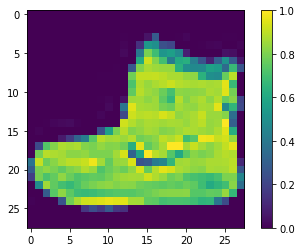

In [10]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0
train_x = train_x.astype('Float32')
test_x = test_x.astype('Float32')
train_y = train_y.astype('int32')
test_y = test_y.astype('int32')
print('total number of train set:', train_x.shape[0])
print('total number of test set:', test_y.shape[0])
print('channel/height/width:', train_x.shape[1:])
print('ground truth label:', train_y[0])  # ten classes, labeled as 0 - 9

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [11]:
###################### Mindspore Dataset ########################
#################################################################

In [12]:
# convert to mindspore Dataset
XY_train = list(zip(train_x, train_y))
ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
ds_train.set_dataset_size(cfg.train_size)
ds_train = ds_train.shuffle(buffer_size=cfg.train_size).batch(cfg.batch_size, drop_remainder=True).repeat(
    cfg.epoch_size)
XY_test = list(zip(test_x, test_y))
ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
ds_test.set_dataset_size(cfg.test_size)
ds_test = ds_test.shuffle(buffer_size=cfg.test_size).batch(cfg.batch_size, drop_remainder=True).repeat(cfg.epoch_size)

In [13]:
#### Define, construct and train feedforward neural network #####
#################################################################

In [14]:
# define feedforward neural network
class Forward_fashion(nn.Cell):
    def __init__(self, num_class=10):  # ten classes, number of channel is 1
        super(Forward_fashion, self).__init__()
        self.num_class = num_class
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(cfg.channel * cfg.image_height * cfg.image_width, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [15]:
# construct network
network = Forward_fashion(cfg.num_classes)
# define loss function and optimizer
net_loss = nn.SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction="mean")
net_opt = nn.Adam(network.trainable_params(), cfg.lr)
# train model
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})
loss_cb = LossMonitor(per_print_times=int(cfg.train_size / cfg.batch_size))
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix=cfg.output_prefix, directory=cfg.output_directory, config=config_ck)
print("============== Starting Training ==============")
model.train(cfg.epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb], dataset_sink_mode=True)

============== Starting Training ==============
epoch: 1 step 1000, loss is 0.6608248949050903
Epoch time: 11269.183, per step time: 11.269, avg loss: 0.661
************************************************************
epoch: 2 step 1000, loss is 0.4753102660179138
Epoch time: 2213.876, per step time: 2.214, avg loss: 0.475
************************************************************
epoch: 3 step 1000, loss is 0.3378944993019104
Epoch time: 2039.513, per step time: 2.040, avg loss: 0.338
************************************************************
epoch: 4 step 1000, loss is 0.2762758731842041
Epoch time: 2003.875, per step time: 2.004, avg loss: 0.276
************************************************************
epoch: 5 step 1000, loss is 0.14267194271087646
Epoch time: 1918.509, per step time: 1.919, avg loss: 0.143
************************************************************
epoch: 6 step 1000, loss is 0.4918135106563568
Epoch time: 2139.842, per step time: 2.140, avg loss: 0.492
**

In [16]:
################ Model evaluation and prediction ################
#################################################################

In [17]:
# evaluation by test set
metric = model.eval(ds_test)
print(metric)

# predict
test_ = ds_test.create_dict_iterator().get_next()
test = Tensor(test_['x'], mindspore.float32)
predictions = model.predict(test)
softmax = nn.Softmax()
predictions = softmax(predictions)
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('No.' + str(i) + ' sample predict result：', p_list.index(max(p_list)), '   ground truth label：', test_['y'][i])

moxing.file.copy_parallel(src_url='model_fashion', dst_url='obs://feedforward-demo2/feedforward/model_fashion')

{'acc': 0.8860441767068273}
No.0 sample predict result： 1    ground truth label： 1
No.1 sample predict result： 9    ground truth label： 9
No.2 sample predict result： 2    ground truth label： 2
No.3 sample predict result： 1    ground truth label： 1
No.4 sample predict result： 9    ground truth label： 9
No.5 sample predict result： 7    ground truth label： 9
No.6 sample predict result： 8    ground truth label： 8
No.7 sample predict result： 9    ground truth label： 9
No.8 sample predict result： 8    ground truth label： 8
No.9 sample predict result： 1    ground truth label： 1
No.10 sample predict result： 4    ground truth label： 4
No.11 sample predict result： 2    ground truth label： 2
No.12 sample predict result： 9    ground truth label： 9
No.13 sample predict result： 3    ground truth label： 3
No.14 sample predict result： 9    ground truth label： 9


In [18]:
################# Predicted result visualization ################
#################################################################

In [19]:
# input: predicted result, ground truth label, image
# correct predicted result: blue, wrong predicted result: red
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # plot corresponding image
    plt.imshow(img, cmap=plt.cm.binary)
    # show the color, indicating correct(blue) or wrong(red) predicted result
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # format of display
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]), color=color)

In [20]:
# histogram shows the correct(blue) or wrong(red) predicted result
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

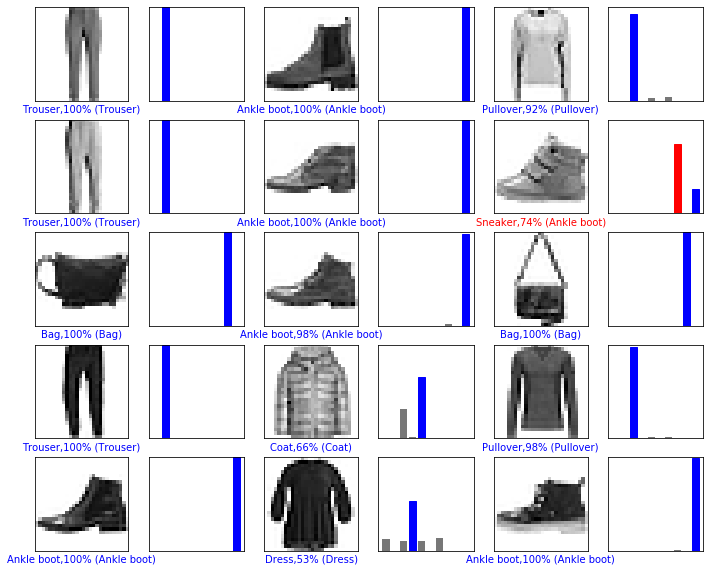

In [21]:
# predict and show 15 images' labels
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]  
    plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(pred_np_, test_['y'][i])
plt.show()